
## **Decision Tree Classifier**




In [36]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import graphviz
from io import StringIO

**Dataset loading and Data Preprocessing**

In [4]:
# Loading the dataset
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [5]:
# Lookign at the data types of the feature columns and the target column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None


We observe that we have 3 features with obkect data type and the target variable is of object data type too.


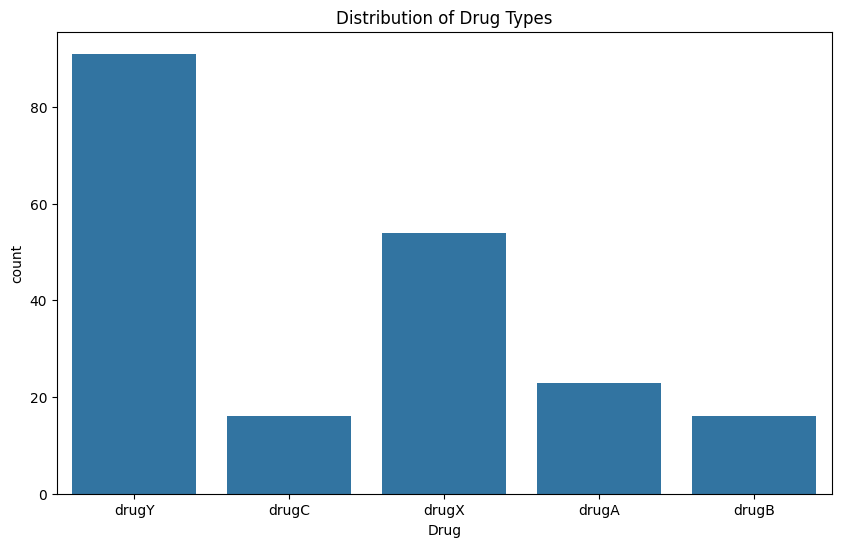

In [23]:
# Plotting the target colum , where we look at the count of each category in the column
plt.figure(figsize=(10, 6))
sns.countplot(x='Drug', data=df)
plt.title('Distribution of Drug Types')
plt.show()

In [7]:
# Encode categorical variables
df_encoded = df.copy()
df_encoded['Sex'] = df_encoded['Sex'].map({'F': 0, 'M': 1})
df_encoded['BP'] = df_encoded['BP'].map({'LOW': 0, 'NORMAL': 1, 'HIGH': 2})
df_encoded['Cholesterol'] = df_encoded['Cholesterol'].map({'NORMAL': 0, 'HIGH': 1})
drug_mapping = {'drugY': 0, 'drugX': 1, 'drugC': 2, 'drugA': 3, 'drugB': 4}
df_encoded['Drug'] = df_encoded['Drug'].map(drug_mapping)

print(df_encoded.head())

   Age  Sex  BP  Cholesterol  Na_to_K  Drug
0   23    0   2            1   25.355     0
1   47    1   0            1   13.093     2
2   47    1   0            1   10.114     2
3   28    0   1            1    7.798     1
4   61    0   0            1   18.043     0


In [37]:
# Extract features and target

X = df_encoded[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
y = df_encoded['Drug'].values

**Train-Test Data Split**

Randomly split the dataset into training and testing sets.

  X: Feature matrix (numpy array)

  y: Target vector (numpy array)

  "test_size": Proportion of the dataset to include in the test split (default 0.2)


In [9]:
# Custom train-test split function
def train_test_split(X, y, test_size=0.2, random_state=42):
    """Split data into train and test sets."""
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size) # number of test samples
    test_indices = indices[:test_size]     # indicies for test set
    train_indices = indices[test_size:]    # indicies for train set
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

In [10]:
# Splitting the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining Set Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Set Shape: {X_test.shape}, {y_test.shape}")


Training Set Shape: (160, 5), (160,)
Test Set Shape: (40, 5), (40,)


**Decision Tree Implementation**

Class Node represents a single node in the decison tree.

Each node can be **decision** (also called as split) or a **leaf node**

In [38]:
# Node class for decision tree structure
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature = feature      # Feature index for splitting
        self.threshold = threshold  # Threshold for numerical splits
        self.left = left        # Left child node
        self.right = right      # Right child node
        self.gain = gain         # Information gain from split
        self.value = value       # Leaf node class label

Below are the menthods being implementd under the decision tree classifier

1. Entropy Calculation: It measures the impurity (randomness) in the data.

2. Information Gain: It calculates how much a split improves the purity.

3. Best Split: Helps to find the best feature and the value to split on

4. Calculating Leaf Value: It finds the most common class in a leaf node.

5. Build Tree: The method recursively build the tree by splitting data.

6. Fit Method: It trains the decision tree on the data.

7. Prediction: It predcited the class for single sample and then predict classes for all the samples

In [40]:
# Implementing the Decision Tree from scratch
class DecisionTree:
    def __init__(self, min_samples=2, max_depth=3):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.root = None
    # Calculating Entropy
    def calculate_entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return -np.sum(probs * np.log2(probs + 1e-10))

    # Information Gain
    def information_gain(self, parent, left, right):
        parent_entropy = self.calculate_entropy(parent)
        n = len(parent)
        n_left, n_right = len(left), len(right)
        if n_left == 0 or n_right == 0:
            return 0
        child_entropy = (n_left / n) * self.calculate_entropy(left) + (n_right / n) * self.calculate_entropy(right)
        return parent_entropy - child_entropy

    # Finding the Best Split for the data
    def best_split(self, dataset, n_samples, n_features):
        best_split = {"gain": 0}
        for feature in range(n_features):
            values = np.unique(dataset[:, feature])
            for value in values:
                left_indices = dataset[:, feature] <= value
                right_indices = dataset[:, feature] > value
                if np.sum(left_indices) > 0 and np.sum(right_indices) > 0:
                    left_y, right_y = dataset[left_indices, -1], dataset[right_indices, -1]
                    gain = self.information_gain(dataset[:, -1], left_y, right_y)
                    if gain > best_split["gain"]:
                        best_split = {
                            "feature": feature,
                            "threshold": value,
                            "left_dataset": dataset[left_indices],
                            "right_dataset": dataset[right_indices],
                            "gain": gain
                        }
        return best_split

    # Calculating the leaf node class
    def calculate_leaf_value(self, y):
        return np.bincount(y.astype(int)).argmax()

    # Recursively building the decision tree
    def build_tree(self, dataset, depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples and depth <= self.max_depth:
            best_split = self.best_split(dataset, n_samples, n_features)
            if best_split["gain"] > 0:
                left_node = self.build_tree(best_split["left_dataset"], depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], depth + 1)
                return Node(best_split["feature"], best_split["threshold"], left_node, right_node, best_split["gain"])
        return Node(value=self.calculate_leaf_value(y))

    # Decision Tree Traning
    def fit(self, X, y):
        dataset = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(dataset)

    # Predict single instance by traversing tree.
    def make_prediction(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.make_prediction(x, node.left)
        return self.make_prediction(x, node.right)

    # Predict class labels for all instances.
    def predict(self, X):
        return np.array([self.make_prediction(x, self.root) for x in X])



**Metrics and Evaluation**

In [31]:
# Fucntion to calculate  Standarad Accuracy
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Fucntion to compute the Confusion Matrix
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


**Traning and Predcition**

In [32]:
# Train the decision tree and evaluate its accuracy
model = DecisionTree(min_samples=2, max_depth=3)
model.fit(X_train, y_train)
print("\nModel Training Completed.")

predictions = model.predict(X_test)
acc = accuracy(y_test, predictions)
print(f"\nModel Accuracy: {acc:.4f}")



Model Training Completed.

Model Accuracy: 1.0000


**Visualization**

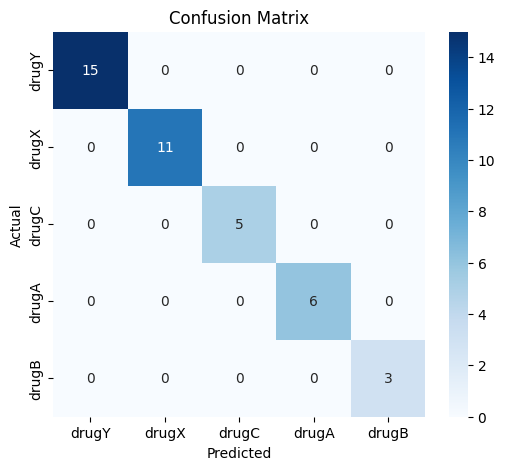

In [28]:
# Confusion Matrix as a heatmap
cm = confusion_matrix(y_test, predictions, num_classes=5)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(drug_mapping.keys()),
            yticklabels=list(drug_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Observation:**
Prefect Classification: In the matrix, it shows that every drug class is perfectly predicted (since all the non-diagonal values are equal to 0)


In [29]:
# Decision Tree Visualization
def print_tree(node, feature_names, spacing=""):
    """Recursively print the tree structure."""
    if node.value is not None:
        print(spacing + f"Predict: {list(drug_mapping.keys())[node.value]}")
        return
    print(spacing + f"[{feature_names[node.feature]} <= {node.threshold:.2f}] (gain={node.gain:.3f})")
    print(spacing + '--> True:')
    print_tree(node.left, feature_names, spacing + "  ")
    print(spacing + '--> False:')
    print_tree(node.right, feature_names, spacing + "  ")

print("\nDecision Tree Structure:")
feature_names = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
print_tree(model.root, feature_names)


Decision Tree Structure:
[Na_to_K <= 14.64] (gain=0.998)
--> True:
  [BP <= 1.00] (gain=0.940)
  --> True:
    [BP <= 0.00] (gain=0.304)
    --> True:
      [Cholesterol <= 0.00] (gain=0.999)
      --> True:
        Predict: drugX
      --> False:
        Predict: drugC
    --> False:
      [Age <= 15.00] (gain=0.000)
      --> True:
        Predict: drugX
      --> False:
        Predict: drugX
  --> False:
    [Age <= 50.00] (gain=0.987)
    --> True:
      [Age <= 43.00] (gain=0.000)
      --> True:
        Predict: drugA
      --> False:
        Predict: drugA
    --> False:
      [Age <= 51.00] (gain=0.000)
      --> True:
        Predict: drugB
      --> False:
        Predict: drugB
--> False:
  [Age <= 33.00] (gain=0.000)
  --> True:
    Predict: drugY
  --> False:
    Predict: drugY


In [33]:
# Decision Tree Visualization
# Exporting the decision tree structure to a graphical image using Graphviz
from graphviz import Digraph

def export_tree_to_graphviz(node, feature_names, drug_mapping, dot=None, node_id=0):
    """Recursively export the tree to Graphviz format."""
    if dot is None:
        dot = Digraph()
    current_id = str(node_id)
    if node.value is not None:
        label = f"Predict: {list(drug_mapping.keys())[node.value]}"
        dot.node(current_id, label, shape='box', style='filled', color='lightblue')
        return dot, node_id
    label = f"{feature_names[node.feature]} <= {node.threshold:.2f}\n(gain={node.gain:.3f})"
    dot.node(current_id, label)
    # Left child (True branch)
    left_id = node_id + 1
    dot, left_id = export_tree_to_graphviz(node.left, feature_names, drug_mapping, dot, left_id)
    dot.edge(current_id, str(node_id + 1), label="True")
    # Right child (False branch)
    right_id = left_id + 1
    dot, right_id = export_tree_to_graphviz(node.right, feature_names, drug_mapping, dot, right_id)
    dot.edge(current_id, str(left_id + 1), label="False")
    return dot, right_id

# Usage:
feature_names = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
dot, _ = export_tree_to_graphviz(model.root, feature_names, drug_mapping)
dot.render('decision_tree', format='png', cleanup=True)  # This will create 'decision_tree.png'

'decision_tree.png'

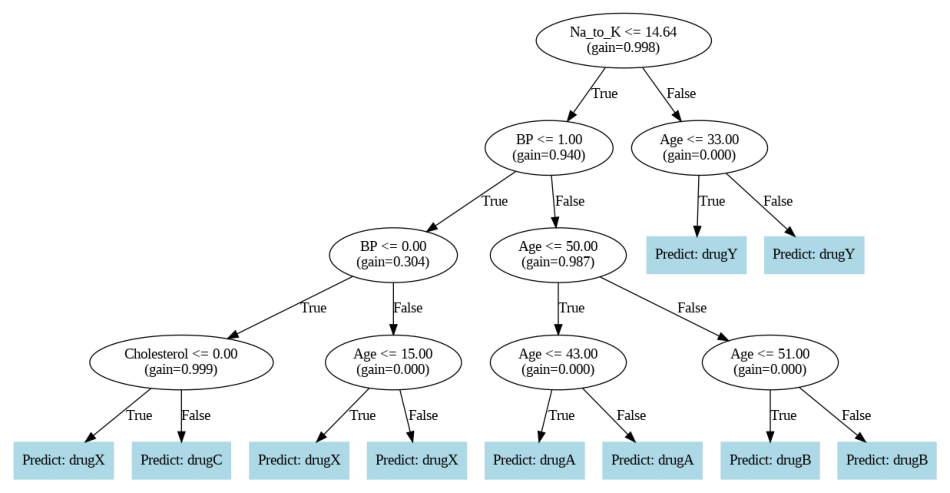

In [35]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('decision_tree.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()